In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
import os
from tqdm import tqdm



import warnings
warnings.filterwarnings('ignore')


In [32]:
df = pd.read_csv("HR_comma_sep.csv")

In [33]:
df.head(2)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium


In [34]:
X= df.drop('left', axis = 1)


In [35]:
y= df['left']

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=24,test_size=0.3,stratify=y)

In [37]:
ohe = OneHotEncoder(sparse_output=False, drop='first').set_output(transform='pandas')
ct = make_column_transformer(('passthrough', make_column_selector(dtype_exclude=object)  ),
                             (ohe,make_column_selector(dtype_include=object)  ),
                             verbose_feature_names_out=False).set_output(transform='pandas')

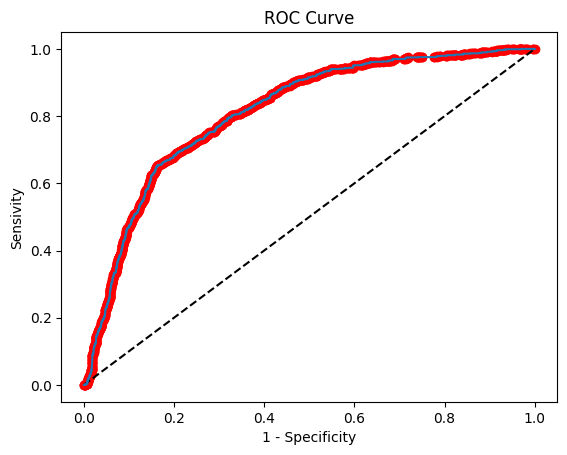

0.8108072160761836


In [39]:
lr = LogisticRegression(random_state=24)
pipe = Pipeline([('CT',ct),('SCL',None),('LR',lr)])

pipe.fit(X_train, y_train)
y_pred_prob= pipe.predict_proba(X_test)
p_y_1= y_pred_prob[:,1]

m1spec, sens, thresholds = roc_curve(y_test,p_y_1)
plt.plot([0,1],[0,1], 'k--')
plt.plot(m1spec,sens)
plt.scatter(m1spec, sens, c='red')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensivity')
plt.title('ROC Curve')
plt.show()
print(roc_auc_score(y_test, p_y_1))



kfold = StratifiedKFold(n_splits=5, random_state=24, shuffle=True)

params = {'LR__solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga'], 'LR__multi_class':['ovr','multinomial'],'LR__C':np.linspace(0.001, 10, 20)}

In [8]:
gcv = GridSearchCV(pipe, param_grid=params, cv=kfold, verbose=3)

In [9]:
gcv.fit(X,y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=0.760 total time=   0.1s
[CV 2/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=0.759 total time=   0.1s
[CV 3/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=0.761 total time=   0.1s
[CV 4/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=0.760 total time=   0.1s
[CV 5/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=lbfgs;, score=0.755 total time=   0.1s
[CV 1/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=liblinear;, score=0.762 total time=   0.0s
[CV 2/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=liblinear;, score=0.762 total time=   0.0s
[CV 3/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=liblinear;, score=0.762 total time=   0.0s
[CV 4/5] END LR__C=0.001, LR__multi_class=ovr, LR__solver=liblinear;, score=0.762 total time=   0.0s
[CV 5/5] END LR__C=0.001, LR__multi_class=ovr, 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=24, shuffle=True),
             estimator=Pipeline(steps=[('CT',
                                        ColumnTransformer(transformers=[('passthrough',
                                                                         'passthrough',
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000255CFE378F0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transfor...
       2.10605263e+00, 2.63231579e+00, 3.15857895e+00, 3.68484211e+00,
       4.21110526e+00, 4.73736842e+00, 5.26363158e+00, 5.78989474e+00,
       6.31615789e+00, 6.84242105e+00, 7.36868421e+00, 7.89494737e+00,
       8.42121053e+00, 8.94747368e+00, 9.47373684e+00, 1.00000000e+01]),
                         'LR__multi_class': ['ovr', 'multinomial'],
                         'LR__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                        'newton-cholesky', 'sag', 'saga']},
             verbose=3)

In [12]:
print(gcv.best_params_)
print(gcv.best_score_)

{'LR__C': 10.0, 'LR__multi_class': 'ovr', 'LR__solver': 'lbfgs'}
0.8034011337112371


In [13]:
pd_cv= pd.DataFrame(gcv.cv_results_)
print(pd_cv.shape)

(240, 16)


In [16]:
###### Inferencing
best_model = gcv.best_estimator_

In [18]:
tst= pd.read_csv("tst_hr.csv")
print(best_model.predict(tst))

[1 0 1 1 0 0 1 0 0 0 0 0 0 0 0]


In [19]:
tst['predictions'] = best_model.predict(tst)

In [20]:
tst['predictions']

0     1
1     0
2     1
3     1
4     0
5     0
6     1
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
Name: predictions, dtype: int64

In [22]:
best_model.predict_proba(tst)

array([[0.48453284, 0.51546716],
       [0.78329234, 0.21670766],
       [0.41842353, 0.58157647],
       [0.46743117, 0.53256883],
       [0.85097459, 0.14902541],
       [0.99326891, 0.00673109],
       [0.36745542, 0.63254458],
       [0.59586212, 0.40413788],
       [0.89032653, 0.10967347],
       [0.93939148, 0.06060852],
       [0.95768583, 0.04231417],
       [0.837211  , 0.162789  ],
       [0.76908598, 0.23091402],
       [0.95716544, 0.04283456],
       [0.86091294, 0.13908706]])

### ROC CURVE